# CIS6800: Project 1b: Deep Learning Basics Part B

### Instructions:
* This is an individual assignment. Collaborating with others is not permitted.
* There is no single answer to most problems in deep learning, therefore the questions will often be underspecified. You need to fill in the blanks and submit a solution that solves the (practical) problem. Document the choices (hyperparameters, features, neural network architectures, etc.) you made where specified.
* All the code should be written in Python. You should only use PyTorch to complete this project.
* You are encouraged to use ChatGPT, but you need to make a summary of how you used it, and the code that you have copied from it.



In [9]:

import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms, utils
from torch.utils.data import ConcatDataset
import torch.optim as optim

import random
"""
%matplotlib inline
rng_seed = 45510

# Download MNIST
torchvision.datasets.MNIST('.', download=True)
"""

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train

## 4. Adversarial Images (30%)
In this part you will see how you can use the gradients of the network to generate adversarial
images. Using these images that look almost identical the original you will be able to fool
different neural networks. You will also see that these images also affect different neural
networks and expose a security issue of CNNs that malicious users can take advantage of.
An example is shown in Figure 4. You are encouraged to read the relevant papers [1, 2]
before solving this part.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW1/images/fig4.png"/></div>

<center>Figure 4: An adversarial example demonstrated in [1].</center>

1. (10%) Use the trained network from question 3 to generate adversarial images with
constraints. The constraints that you have are:

  1. You are not allowed to erase parts of the image, i.e. $I_\text{pert} \ge I$ at each pixel location.
  2. The perturbed image has to take valid values, i.e. $-1 \le I_\text{pert} \le 1$.

  The algorithm works as follows:
  
  1. Let $I$ be a test image of your dataset that you want to perturb that is classified correctly by the network. Let $I_\epsilon$ be the perturbation that you should initialize
with zeros.
  2. Feed $I_\text{pert} = I + I_\epsilon$ in the network.
  3. Calculate the loss given the ground truth label ($y_\mathrm{gt}$). Let the loss be $L(x,y |\theta)$ where $\theta$ are the learned weights.
  4. Compute the gradients with respect to $I_\text{pert}$, i.e., $\nabla_{I_\text{pert}} L(I_\text{pert}, y_\mathrm{gt} | \theta)$. Using backpropagation, compute $\nabla_{I_\epsilon} L(I_\epsilon,y_\mathrm{gt} | \theta)$, i.e. the gradients with respect to the perturbation.
  5. Use the Fast Gradient Sign method to update the perturbation, i.e., $I_\epsilon = I_\epsilon + \epsilon\,\text{sign}(\nabla_{I_\epsilon} L(I_\epsilon, y_\mathrm{gt}))$, where $\epsilon$ is a small constant of your choice.
  6. Repeat A-D until the network classify the input image $I_\text{pert}$ as an arbitrary
wrong category with confidence (probability) at least $90\%$.

  Generate 2 examples of adversarial images. Describe the difference between the adversarial images and the original images.

In [11]:
# CUDA for PyTorch
"""
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
"""
# Create your network here (do not change this name)
class DigitClassification(torch.nn.Module):
    def __init__(self):
      super(DigitClassification, self).__init__()
      self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=5, padding='same')
      self.bn1 = torch.nn.BatchNorm2d(32)
      self.relu1 = torch.nn.ReLU()
      self.pool1 = torch.nn.AvgPool2d(kernel_size = 2, stride = 2, padding = 0)

      self.conv2 = torch.nn.Conv2d(32,32,kernel_size = 5, padding = 'same')
      self.bn2 = torch.nn.BatchNorm2d(32)
      self.relu2 = torch.nn.ReLU()
      self.pool2 = torch.nn.AvgPool2d(kernel_size = 2, stride = 2, padding = 0)

      self.conv3 = torch.nn.Conv2d(32,64,kernel_size = 5, padding = 'same')
      self.bn3 = torch.nn.BatchNorm2d(64)
      self.relu3 = torch.nn.ReLU()
      self.pool3   = torch.nn.AvgPool2d(kernel_size = 2, stride = 2, padding = 0)

      self.linear1 = torch.nn.Linear(576,64)
      self.bn4 = torch.nn.BatchNorm1d(64)
      self.relu4 = torch.nn.ReLU()

      self.linear2 = torch.nn.Linear(64,10)



    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = x.view(x.size(0), -1)

        x = self.linear1(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.linear2(x)

        return x

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

model_path = 'model.pth'
model = DigitClassification()
model = model.to(device)
#model.eval().load_state_dict(torch.load(model_path, map_location=device))


<All keys matched successfully>

In [25]:
# don't change the signature of this function (image, image_pert -> [N, 1, H, W])
def arbitrary_adversary(model, images, original_label):
    epsilon = 0.07
    #setting the model in evaluation mode for reference
    model.eval()

    pert_images = images.clone().detach().requires_grad_(True).to(device)

    while(True):
      output = model(pert_images)
      loss = torch.nn.functional.cross_entropy(output, original_label)
      model.zero_grad()
      loss.backward()

      sgn_gradient = torch.sgn(pert_images.grad.data)
      pert_images.data = pert_images.data + (epsilon*sgn_gradient)

      # Check to ensure Ipert >= I
      pert_images = torch.where(pert_images < images, images, pert_images)
      # i will have to set the gradient true again
      pert_images.data = torch.clamp(pert_images.data, -1, 1)
      pert_images = pert_images.data.clone().detach().requires_grad_(True)


      # Re-classify the perturbed image
      outputs = model(pert_images)

      #now we need to find predicted category and confidence of model's prediction and see if it is>=90%
      probabilities = torch.nn.functional.softmax(outputs,dim=1)
      max_prob, prediction = torch.max(probabilities,dim=1)

      target_matched = (max_prob >=0.90) & (prediction!= original_label)
      if target_matched.all():
        print("all images misclassified with high confidence")
        break

    return pert_images


# Display images
def display(image, perturbed_image, label):
  fig = plt.figure(figsize = (10,10))

  plt.subplot(1,2,1)
  plt.imshow(image.cpu().squeeze().numpy())
  plt.title('Original Image')


  plt.subplot(1,2,2)
  plt.imshow(perturbed_image.detach().cpu().squeeze().numpy())
  plt.title('Perturbed Image')
  plt.text(-20,32,'Original Label: {}'.format(label.item()))


  plt.show()





all images misclassified with high confidence


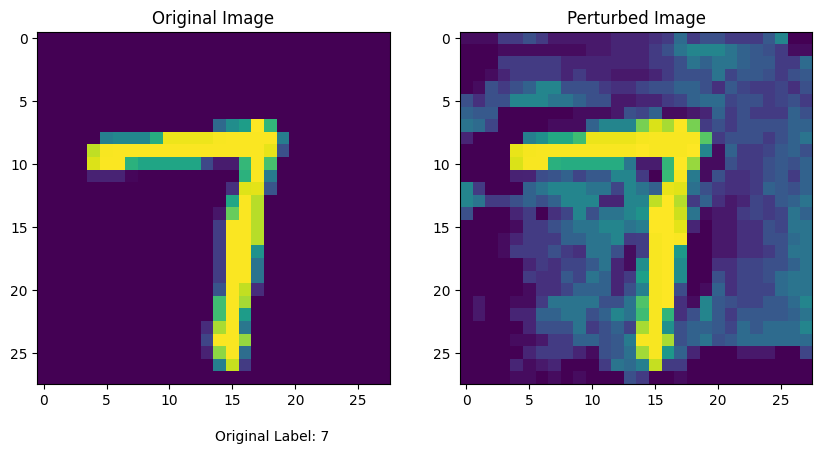

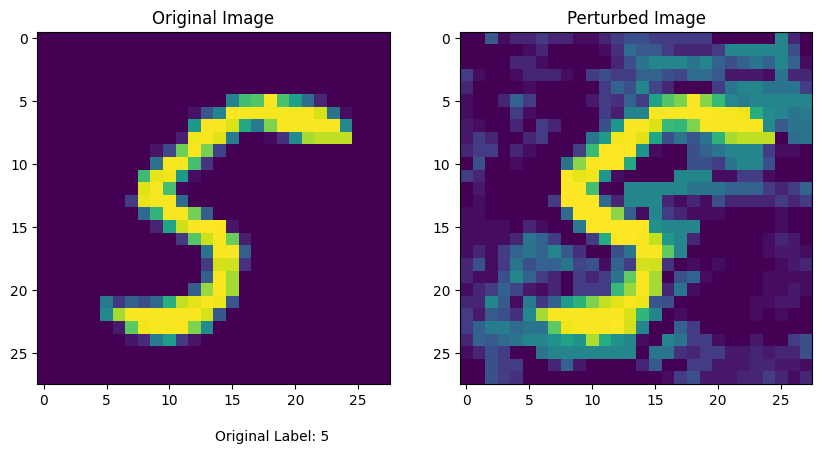

In [26]:
"""
tr = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5),(0.5))])
test_dataset = torchvision.datasets.MNIST(root='./data',train=False,download=True,transform= tr)
bs = 10
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size = bs, shuffle =True)

iterator = iter(test_dataloader)
images,labels = next(iterator)
pert_images = arbitrary_adversary(model.to(device), images.to(device), labels.to(device))

#display images
for i in range(2):
  display(images[i],pert_images[i], labels[i])

"""

#### **As shown above are two images. The left image of each plot is the original image and the right is perturbed image. To human eye, the digit in perturbed image looks still the same as the digit in the original image. Pixel colors have been modified in the perturbed image. The pixel values are still in range [-1,1] and no parts of the image are erased. Yet we see that the model predicted the label wrong with 100% confidence. This shows how adversarial attacks can break any model**

2. (10%) For a test image from the dataset, choose a target label yt that you want the network to classify your image as and compute a perturbed image. Note that this is different from what you are asked in part 1, because you want your network to believe that the image has a particular label, not just misclassify the image. You need to modify appropriately the loss function and then perform gradient descent as before. You should still use the constraints from part 1.

In [27]:
# don't change the signature of this function (image, image_pert -> [N, 1, H, W])
def targeted_adversary(model, images, target_label):
    epsilon = 0.01
    #setting the model in evaluation mode for reference
    model.eval()

    pert_images = images.clone().detach().requires_grad_(True).to(device)

    for i in range(100):
      output = model(pert_images)
      loss = torch.nn.functional.cross_entropy(output, target_label)
      model.zero_grad()
      loss.backward()

      sgn_gradient = torch.sgn(pert_images.grad.data)
      pert_images.data = pert_images.data - (epsilon*sgn_gradient)
      # minus instead of plus because we want the loss to be minimized in this case

      # Check to ensure Ipert >= I
      pert_images = torch.where(pert_images < images, images, pert_images)

      pert_images.data = torch.clamp(pert_images.data, -1, 1)
      pert_images = pert_images.data.clone().detach().requires_grad_(True)

      # Re-classify the perturbed image
      outputs = model(pert_images)

      #now we need to find predicted category and confidence of model's prediction and see if it is>=90%
      probabilities = torch.nn.functional.softmax(outputs,dim=1)
      max_prob, prediction = torch.max(probabilities,dim=1)

      # Check if all predictions meet the criteria
      target_matched = (max_prob >= 0.90) & (prediction == target_label)
      if target_matched.all():
          print("All images have reached the target label.")
          break

    return pert_images


# Display images
def display_targeted(image, perturbed_image, label,target):
  fig = plt.figure(figsize = (10,10))

  plt.subplot(1,2,1)
  plt.imshow(image.cpu().squeeze().numpy())
  plt.title('Original Image')


  plt.subplot(1,2,2)
  plt.imshow(perturbed_image.detach().cpu().squeeze().numpy())
  plt.title('Perturbed Image')
  plt.text(-20,32,'Original Label: {}, Target Label : {}'.format(label.item(), target.item()))


  plt.show()

All images have reached the target label.


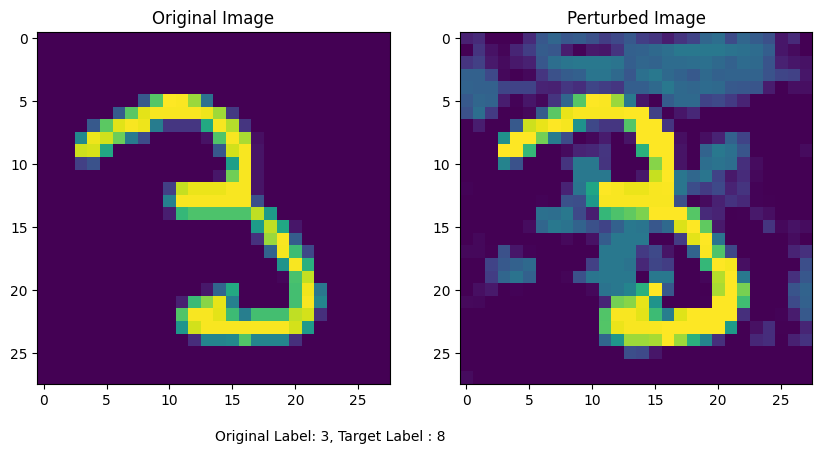

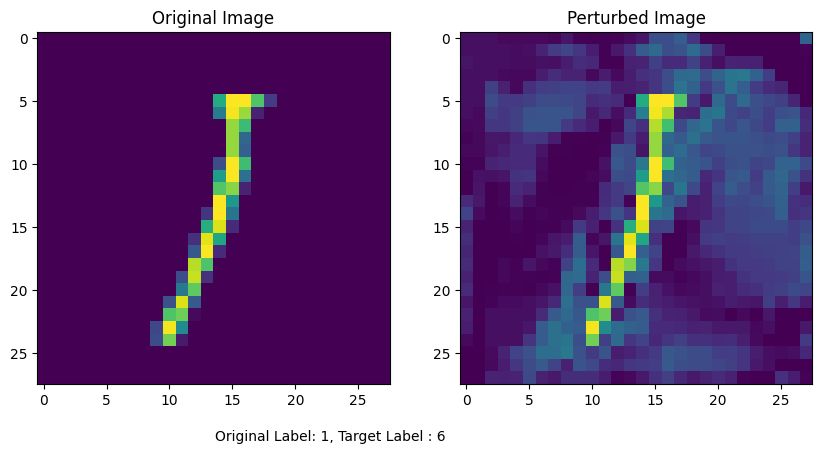

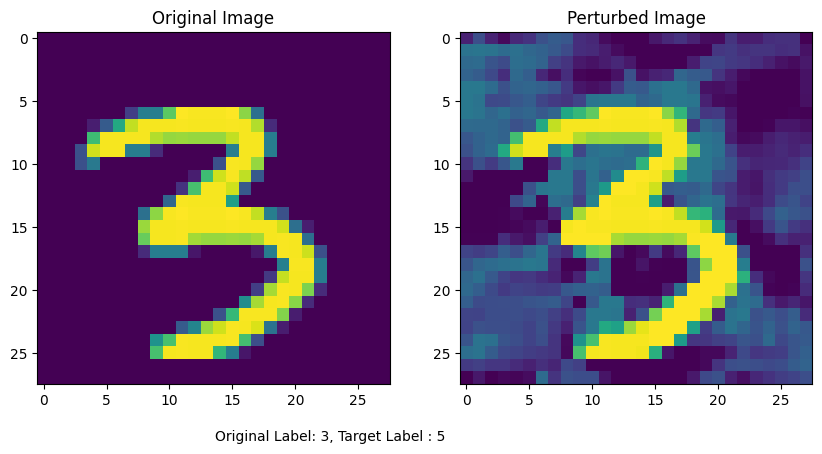

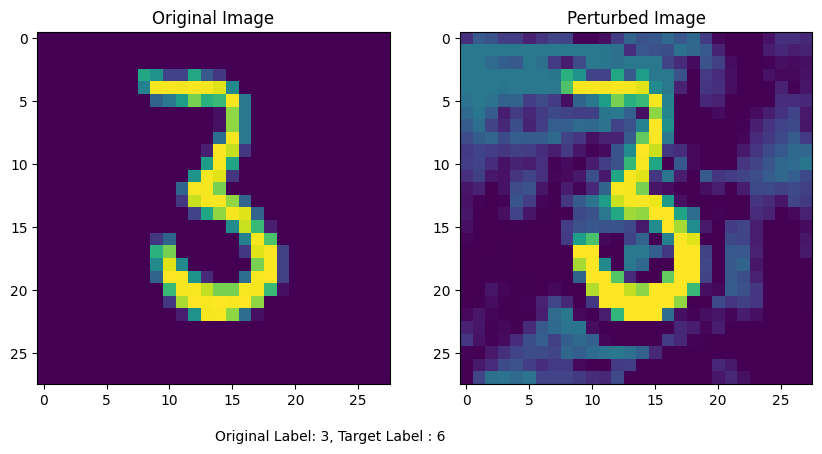

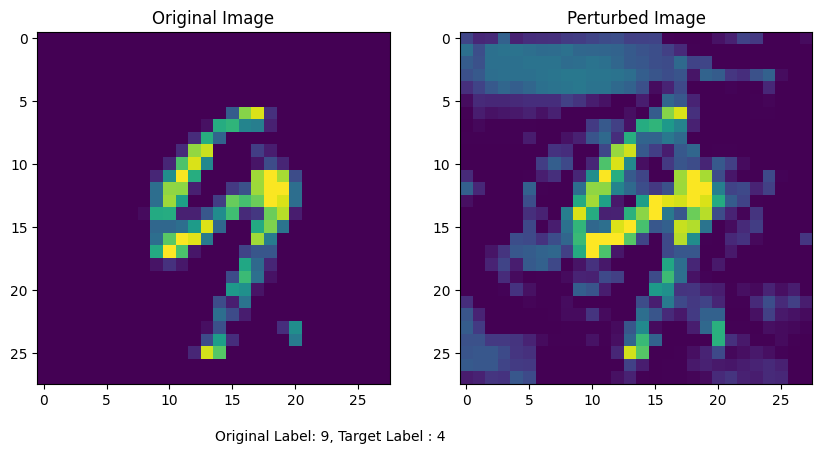

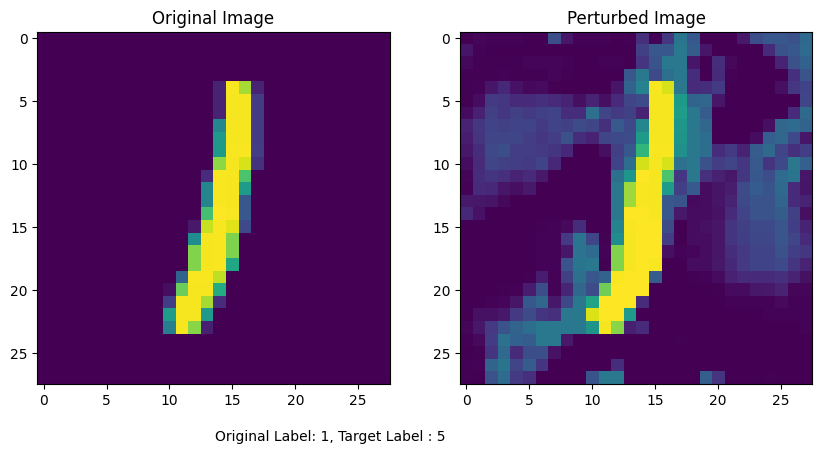

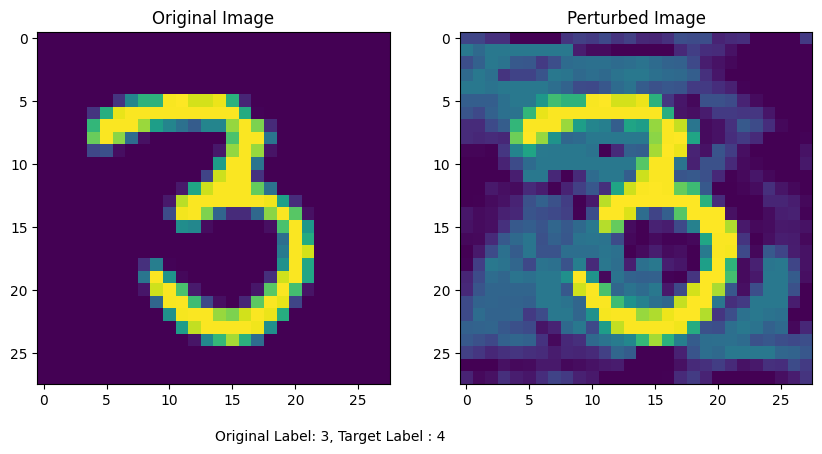

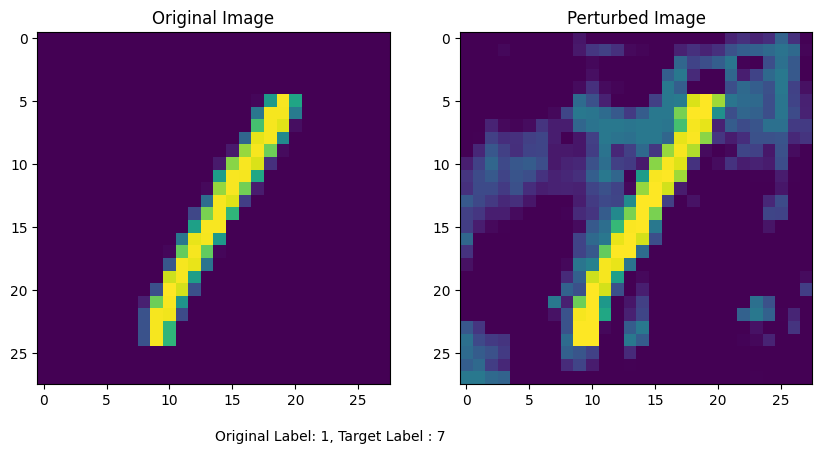

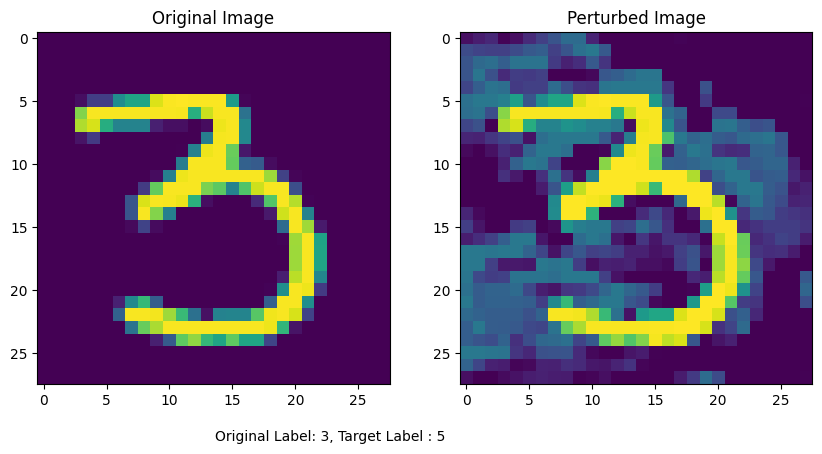

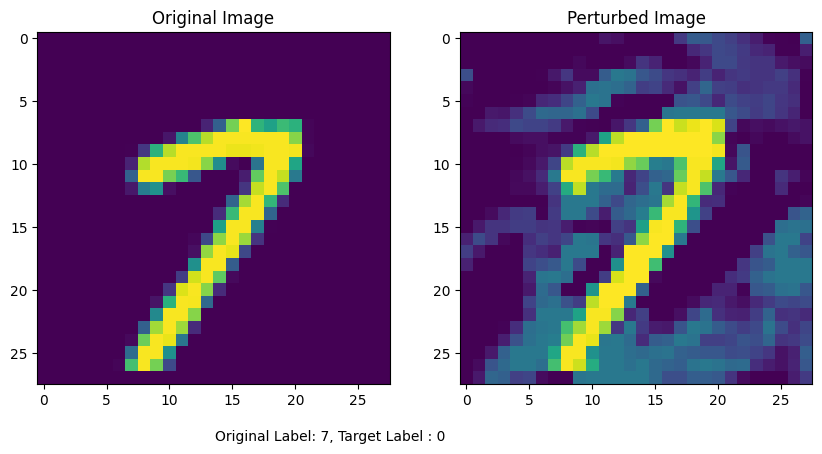

In [28]:
"""
tr = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5),(0.5))])
test_dataset = torchvision.datasets.MNIST(root='./data',train=False,download=True,transform= tr)
bs = 10
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size = bs, shuffle =True)
iterator = iter(test_dataloader)
images,labels = next(iterator)
images = images.to(device)
labels = labels.to(device)

target_labels = torch.randint(0, 9, (bs,), dtype=torch.long).to(device)
# To make sure that targets are different from originals
same_indices = torch.where(target_labels == labels)[0] # see where both are common and update in target
target_labels[same_indices] = (target_labels[same_indices] + 1) % 10

pert_images= targeted_adversary(model.to(device), images.to(device), target_labels.to(device))

#display images
for i in range(bs):
  display_targeted(images[i],pert_images[i], labels[i], target_labels[i])
"""
#since we are not allowed to change the outputs, i cant show confidence of prediction in plot, but on checking it turned out to be >=0.90

<!-- BEGIN QUESTION -->

3. (10%) Retrain the network from the previous problem. Use some of the adversarial images you generated in parts (1) and (2) and feed them in the retrained network. What do you observe?

In [16]:
"""
from torch.utils.data.dataset import TensorDataset
#1 - Preparing train set for retraining : add adversarial images (formed by passing trainset batch to adversary function) to train set
#2 - Prepare test set & check old model's performance  : combined_testdataset =  adversarial images formed from testdataset +testdataset -> Old model acc & loss
#3 - retrain the network (original train images and labels + adversarial images and correct label)
#4 - Test new model & compare performance

tr = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5),(0.5))])
train_dataset = torchvision.datasets.MNIST(root='./data',train=True,download=True,transform= tr)
test_dataset = torchvision.datasets.MNIST(root='./data',train=False,download=True,transform= tr)

train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size = 64, shuffle =True)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size = 64, shuffle =True)

#1. Form adversarial images from train data and then add these to train set with correct labels
# I will make 1280 adversarial images (20 batches)

iterator = iter(train_dataloader)
images,labels = next(iterator)
images = images.to(device)
labels = labels.to(device)


total_batches = 20
batchno = 0
adversarial_images = None
adversarial_labels = None


#making adversarial images and labels
for images, labels in train_dataloader:
  pert_images, predictions, confidences = arbitrary_adversary(model.to(device), images.to(device), labels.to(device))
  pert_images, predictions, confidences = pert_images.to(device), predictions.to(device), confidences.to(device)
  if batchno == 0:
    adversarial_images = pert_images
    adversarial_labels = labels #adding correct labels only since new model has to be trained on correct labels
  else:
    # Concatenate the current batch to the existing tensors
    adversarial_images = torch.cat((adversarial_images, pert_images), dim=0)
    adversarial_labels = torch.cat((adversarial_labels, labels), dim=0)

  batchno += 1
  if batchno == total_batches:
        break

adversarial_labels = adversarial_labels.to(device)
#making training images and labels from training loader ->we do this because both should be tensordataset for concatenation
train_images = []
train_labels = []

for images, labels in train_dataloader:
    train_images.append(images)
    train_labels.append(labels)

# Concatenate all the tensors along the first dimension
train_images = torch.cat(train_images).to(device)
train_labels = torch.cat(train_labels).to(device)



#make a dataset of these adversarial images and correct labels
adversarial_dataset = TensorDataset(adversarial_images,adversarial_labels)
train_dataset = TensorDataset(train_images, train_labels)

#combine with train dataset
combined_dataset = ConcatDataset([train_dataset, adversarial_dataset])
#60,000 samples increased to 61,280 samples

combined_dataloader = torch.utils.data.DataLoader(combined_dataset,batch_size = 64, shuffle =True)
"""

all images misclassified with high confidence
all images misclassified with high confidence
all images misclassified with high confidence
all images misclassified with high confidence
all images misclassified with high confidence
all images misclassified with high confidence
all images misclassified with high confidence
all images misclassified with high confidence
all images misclassified with high confidence
all images misclassified with high confidence
all images misclassified with high confidence
all images misclassified with high confidence
all images misclassified with high confidence
all images misclassified with high confidence
all images misclassified with high confidence
all images misclassified with high confidence
all images misclassified with high confidence
all images misclassified with high confidence
all images misclassified with high confidence
all images misclassified with high confidence


In [17]:
#2 Forming test adversial images
#Passing just 1 batch
"""
for images, labels in test_dataloader:
    pert_images, predictions, confidences = arbitrary_adversary(model.to(device), images.to(device), labels.to(device))
labels = labels.to(device)
test_adversarial_dataset = TensorDataset(pert_images, labels)
adversary_test_dataloader = torch.utils.data.DataLoader(test_adversarial_dataset, batch_size=64, shuffle=True)

#batch of 64 images is passed to adversary function. perturbations will be made to all these images till model doesnt classify them wrong

#Testing accuracy of our old untrained model on this data. Later we can compare accuracies to see if retraining helped or not

model.eval()

correct = 0
total = 0
total_loss = 0

criterion = nn.CrossEntropyLoss()  # Define the loss function

for inputs, labels in adversary_test_dataloader:
    outputs = model(inputs)
    loss = criterion(outputs, labels)  # Calculate the loss
    total_loss += loss.item()  # Accumulate the loss
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
average_loss = total_loss / len(adversary_test_dataloader)  # Calculate the average loss per sample

print(f'Accuracy of the Old Model on adversarial test images: {accuracy:.2f}%')
print(f'Average loss of the Old Model on adversarial test images: {average_loss:.4f}')

"""

all images misclassified with high confidence
all images misclassified with high confidence
all images misclassified with high confidence
all images misclassified with high confidence
all images misclassified with high confidence
all images misclassified with high confidence
all images misclassified with high confidence
all images misclassified with high confidence
all images misclassified with high confidence
all images misclassified with high confidence
all images misclassified with high confidence
all images misclassified with high confidence
all images misclassified with high confidence
all images misclassified with high confidence
all images misclassified with high confidence
all images misclassified with high confidence
all images misclassified with high confidence
all images misclassified with high confidence
all images misclassified with high confidence
all images misclassified with high confidence
all images misclassified with high confidence
all images misclassified with high

### As seen the old model essentially performed bad
* **Accuracy = 0%**
* **Average Loss = 34.4**

#### This is expected as our adversarial function made the model misclassify on each image with high confidence

In [18]:
#3. Retrain the network
#load model
"""
model_path = 'model.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)


optimizer = optim.Adam(model.parameters(),lr = 0.01)
criterion = nn.CrossEntropyLoss()

num_epochs = 10
for epoch in range(num_epochs):
  print("Epoch %d/%d" % (epoch+1, num_epochs))

  for data, labels in combined_dataloader: #from new dataset
    data, labels = data.to(device), labels.to(device)
    output = model(data)
    loss = criterion(output, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# After above code, model now has updated parameters, hence we use model only to test adversarial data.. It is our new retrained model
retrained_model_path = 'retrained_model.pth'
torch.save(model.state_dict(), retrained_model_path)
"""

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


In [19]:
#step4 - testing model - load images from adversary test loader and test new model
"""
model.eval()

correct = 0
total = 0
total_loss = 0

criterion = nn.CrossEntropyLoss()  # Define the loss function

for inputs, labels in adversary_test_dataloader:
    outputs = model(inputs)
    loss = criterion(outputs, labels)  # Calculate the loss
    total_loss += loss.item()  # Accumulate the loss
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
average_loss = total_loss / len(adversary_test_dataloader)  # Calculate the average loss per sample

print(f'Accuracy on adversarial test images: {accuracy:.2f}%')
print(f'Average loss on adversarial test images: {average_loss:.4f}')

"""

Accuracy on adversarial test images: 100.00%
Average loss on adversarial test images: 0.0015


### As seen our new model that had adversarial training has outperformed our old model by a large margin

* **Old Model's Accuracy = 0%**
* **New Model's Accuracy = 93.75%**

* **Old Model's Loss = 34.4**
* **New Model's Loss = 0.21**

#### Adversarial training has made our model much robust to adversarial attacks

<!-- END QUESTION -->

## References
<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW1/images/refs.png"/, width=600
         ></div>


## Submission

Make sure you have run all cells in your notebook in order before you zip together your submission, so that all images/graphs appear in the output.

Please submit a pdf file alongside with the notebook, in colab, you can use "File -> Print (Ctrl+P)".

For part (b), your submission should consist of two files: this notebook and the saved weights from question 3. There is no need to upload the new, retrained, weights.

Please do not run the training loop in gradescope submission.

**Please save before exporting!**